Generating handwritten digits (from the MNIST dataset) using [Deep Convolutional Generative Adversial Networks ](https://arxiv.org/pdf/1511.06434.pdf). 

GAN's basically consist of a Generator and a Discriminator. I like to think of the *Generator* as a thief that makes counterfiet bank notes, and the *Discriminator* as a policeman trying to detect the counterfiet currency (an analogy derived from the [original Goodfellow paper on GANs](https://arxiv.org/pdf/1406.2661.pdf)). 

On training, the Generator becomes progressively better at producing images that look real, while the Discriminator gets better at telling them apart. Equilibrium is reached when the Discriminator can no longer discriminate between the real images and those produced by the Generator.

Here, the Generator generates handwritten digits resembling the MNIST dataset

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
#to generate GIFs

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
#Setup

#retrieving pathnames matching a specific pattern
import glob

#read/write, manipulate image data
import imageio
import PIL

import time
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from IPython import display


## Load and Prepare Data

In [4]:
# f.keras.datasets.mnist.load_data() Returns: Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.  
#**x_train, x_test**: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).  
#**y_train, y_test**: uint8 arrays of digit labels (integers in range 0-9) with shapes (num_samples,). 

#we wont be requiring the test dataset

(train_images, train_labels), (_,_) =  tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
#reshaping training images
#train_images.shape[0] gives the number of training samples, we set height = width = 28, and channels = 1 for convolutions
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')

#Normalise image values from [-1,1]. As pixels in greyscale range from [0,255], we divide by 127.5 to bring 255 to 2.0
train_images = (train_images - 127.5) / 127.5

In [6]:
#Batch and shuffle the data

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Build

## The Generator

The Generator uses Unsampling (tf.keras.layers.Conv2DTranspose) to produce an image from a random noise (seed). It starts with a Dense layer that takes the seed as input, and unsamples several times till we get the desired output image size (28,28,1)

We use Leaky ReLU (fixes the Dying ReLU problem) as activation for all layers, except the output layer, which uses tanh





In [7]:
def make_generator_model():
  model = tf.keras.Sequential()
  # choosing 7*7, so that after unsampling 3 times, we get 28*28
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape= (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  #None is the batch size
  assert model.output_shape == (None, 7, 7, 256)

  #128= filter size, (5,5)= kernel size
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding= 'same', use_bias= False ))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #final layer uses a tanh activation
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model


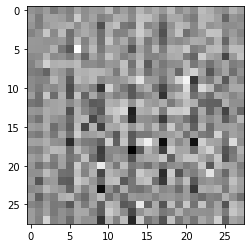

In [8]:
#using the untrained generator to create an image

generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

A CNN based image classifier, trained to output positive values for real images and negative values for fake images

In [9]:
def make_discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00057518]], shape=(1, 1), dtype=float32)


## Loss and Optimizers

Using Binary Cross Entropy as the loss function

In [11]:
#helper funtion to calculate cross entropy loss
#Whether to interpret y_pred as a tensor of logit (log(p/1-p))values. 
#By default, we assume that y_pred contains probabilities (i.e., values in [0, 1]). 
#**Note - Using from_logits=True may be more numerically stable.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

### Discriminator Loss

Quantifies how well discriminator can tell apart the real images from the fakes.
*Compares the discriminator's prediction of real images to an array of 1s, and the discriminator's prediction of fake (generated) images to an array of 0s.*

In [12]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

### Generator Loss

We measure the ability of the generator to trick the discriminator. So, if the generator is performing well, the discriminator classifies the fake (generated) images as real (classifies 1). 

To calculate the generators loss, we compare the discriminators decisions *on the generated (fake) images* to an arrays of 1s.

In [13]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers for the generator and the discrimnator are different as we train the two networks seperately. 
Both the networks use Adam optimizers


In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Saving Checkpoints

To make life easier if interrupted

In [15]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint= tf.train.Checkpoint(generator_optimizer = generator_optimizer, discriminator_optimizer = discriminator_optimizer,
                                generator = generator, discriminator = discriminator)

## Defining the Training Loop


1.   The training loop begins with the generator receiving a random seed as input to produce the image.
2.   The discriminator is then used to classify real images (drawn from the training set) and fake images (generated by the generator). 
3. Losses are calculated for each model, and gradients are used for updating the generator and the discriminator.



In [16]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

#we'll reuse this seed so its easier to visualise the process in GIFs
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
#tf.function causes the function to be compiled
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  #GradientTape(): Operations are recorded if they are executed within this context manager and at least one of their inputs is being "watched".
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #generate images
    generated_images = generator(noise, training = True)

    #real and fake output as identifies by the discriminator
    #real output based on the data set images
    real_output = discriminator(images, training= True)
    #fake ouptu based on the images generated by generator
    fake_output = discriminator(generated_images, training = True)

    #calculate individual losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  #calculate gradients for generator and discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  #optimize to minimize loss and update weights
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    #Produce images for GIFs as we go
    display.clear_output(wait= True)
    generate_and_save_images(generator, epoch +1, seed)

    #Save model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [19]:
#Generate and Save Image

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  #here training is set to false, so all layers run in inference mode(BatchNorm)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train

It is important that *the generator and the discriminator are trained at a similar rate*, so that they dont overpower each other.

Train() calls them both simultaneously. The images start to resemble images after 50 epochs

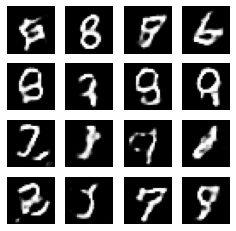

In [20]:
train(train_dataset, EPOCHS)

In [21]:
# Restore last checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Creating GIFs

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

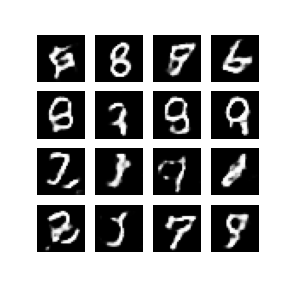

In [23]:
display_image(EPOCHS)

In [24]:
#imageio creates animated gifs using the images saved during trainig
anim_file = 'dcgan.gif'

# "I" is for multiple images
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image) 


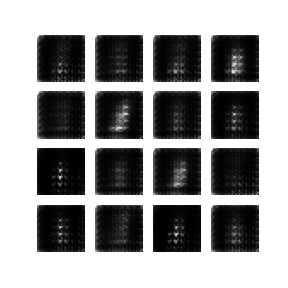

In [25]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)